In [1]:
import sys
!{sys.executable} -m pip install --upgrade "numpy>=2.3,<2.4" "scipy>=1.14" "supervision>=0.23" "tqdm>=4.66" "opencv-python>=4.10" "ipywidgets>=8.1"

  Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl.metadata (19 kB)
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl (39.5 MB)
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.10.0.84
    Uninstalling opencv-python-4.10.0.84:
      Successfully uninstalled opencv-python-4.10.0.84


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inference 0.62.2 requires opencv-python<=4.10.0.84,>=4.8.1.78, but you have opencv-python 4.11.0.86 which is incompatible.
inference-gpu 0.62.2 requires opencv-python<=4.10.0.84,>=4.8.1.78, but you have opencv-python 4.11.0.86 which is incompatible.

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import time, json, shutil, subprocess, sys, platform


def safe_import(name):
    try:
        return __import__(name)
    except Exception:
        return None


def pick_torch_device():
    torch = safe_import("torch")
    if not torch:
        return {"available": False, "reason": "torch not installed"}

    # CUDA (NVIDIA or ROCm builds)
    try:
        if torch.cuda.is_available():
            dev_index = torch.cuda.current_device() if torch.cuda.device_count() else 0
            name = torch.cuda.get_device_name(dev_index)
            return {
                "available": True,
                "backend": "cuda",
                "device": torch.device(f"cuda:{dev_index}"),
                "details": {
                    "cuda_version": getattr(torch.version, "cuda", None),
                    "cudnn": getattr(torch.backends, "cudnn", None) and torch.backends.cudnn.enabled,
                    "device_index": dev_index,
                    "device_name": name,
                },
            }
    except Exception:
        pass

    # Apple MPS
    try:
        if hasattr(torch.backends, "mps") and torch.backends.mps.is_built() and torch.backends.mps.is_available():
            return {
                "available": True,
                "backend": "mps",
                "device": torch.device("mps"),
                "details": {"note": "Apple Metal Performance Shaders"},
            }
    except Exception:
        pass

    # Windows DirectML (AMD/Intel/NVIDIA)
    torch_directml = safe_import("torch_directml")
    try:
        if torch_directml is not None:
            dml_device = torch_directml.device()
            return {
                "available": True,
                "backend": "directml",
                "device": dml_device,
                "details": {"note": "Windows DirectML backend"},
            }
    except Exception:
        pass

    return {"available": False, "reason": "No supported GPU backend found (CUDA/MPS/DirectML)"}


def nvidia_smi_summary():
    if not shutil.which("nvidia-smi"):
        return None
    try:
        res = subprocess.run(
            [
                "nvidia-smi",
                "--query-gpu=name,driver_version,memory.total",
                "--format=csv,noheader,nounits",
            ],
            capture_output=True,
            text=True,
            timeout=2,
        )
        if res.returncode != 0:
            return {"error": res.stderr.strip()[:200]}
        rows = [r.strip().split(",") for r in res.stdout.strip().splitlines() if r.strip()]
        return [
            {"name": a.strip(), "driver": b.strip(), "mem_total_MB": c.strip()}
            for a, b, c in rows
        ]
    except Exception as e:
        return {"error": str(e)[:200]}


def gpu_self_test():
    torch = safe_import("torch")
    dev = pick_torch_device()

    report = {
        "python": sys.version.split()[0],
        "platform": platform.platform(),
        "device_available": dev["available"],
        "backend": dev.get("backend"),
        "details": dev.get("details"),
        "nvidia_smi": nvidia_smi_summary(),
        "compute_test": None,
        "error": None,
    }

    if not dev["available"]:
        report["error"] = dev.get("reason", "unknown")
        print(json.dumps(report, indent=2))
        return

    try:
        # Allocate on the chosen device and do a small matmul
        a = torch.randn((1024, 1024), device=dev["device"])
        b = torch.randn((1024, 1024), device=dev["device"])
        t0 = time.perf_counter()
        c = a @ b
        # Force realization; also sync on CUDA
        _ = float(c[0, 0].item())
        if report["backend"] == "cuda":
            torch.cuda.synchronize()
        dt_ms = (time.perf_counter() - t0) * 1000
        report["compute_test"] = {"ok": True, "op": "1024x1024 matmul", "elapsed_ms": round(dt_ms, 2)}
    except Exception as e:
        report["compute_test"] = {"ok": False}
        report["error"] = str(e)

    print(json.dumps(report, indent=2))


gpu_self_test()


{
  "python": "3.12.6",
  "platform": "Windows-11-10.0.26200-SP0",
  "device_available": false,
  "backend": null,
  "details": null,
  "nvidia_smi": null,
  "compute_test": null,
  "error": "No supported GPU backend found (CUDA/MPS/DirectML)"
}


https://app.roboflow.com/vio-vision/veovision-tnp3c


In [3]:
%pip install -q gdown inference-gpu

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
%pip install -q git+https://github.com/roboflow/sports.git

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## No need to redownload samples (#)

In [ ]:
!gdown -O "0bfacc_0.mp4" "https://drive.google.com/uc?id=12TqauVZ9tLAv8kWxTTBFWtgt2hNQ4_ZF"
!gdown -O "2e57b9_0.mp4" "https://drive.google.com/uc?id=19PGw55V8aA6GZu5-Aac5_9mCy3fNxmEf"
!gdown -O "08fd33_0.mp4" "https://drive.google.com/uc?id=1OG8K6wqUw9t7lp9ms1M48DxRhwTYciK-"
!gdown -O "573e61_0.mp4" "https://drive.google.com/uc?id=1yYPKuXbHsCxqjA9G-S6aeR2Kcnos8RPU"
!gdown -O "121364_0.mp4" "https://drive.google.com/uc?id=1vVwjW1dE1drIdd4ZSILfbCGPD4weoNiu"

In [5]:
import os
os.environ["ONNXRUNTIME_EXECUTION_PROVIDERS"] = "[CUDAExecutionProvider]"

## ball, players, goalkeepers and referees detection

In [6]:
%pip install -q inference
from inference import get_model
import os

ROBOFLOW_API_KEY = os.getenv("ROBOFLOW_API_KEY", "urspUQutaAeYNtL3l5Nq")
PLAYER_DETECTION_MODEL_ID = "veovision-tnp3c/1"
PLAYER_DETECTION_MODEL = get_model(
    model_id=PLAYER_DETECTION_MODEL_ID,
    api_key=ROBOFLOW_API_KEY
)



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


ModelDependencyMissing: Your `inference` configuration does not support SAM model. Use pip install 'inference[sam]' to install missing requirements.To suppress this warning, set CORE_MODEL_SAM_ENABLED to False.
ModelDependencyMissing: Your `inference` configuration does not support SAM2 model. Use pip install 'inference[sam]' to install missing requirements.To suppress this warning, set CORE_MODEL_SAM2_ENABLED to False.
ModelDependencyMissing: Your `inference` configuration does not support SAM3 model. Install SAM3 dependencies and set CORE_MODEL_SAM3_ENABLED to True.
ModelDependencyMissing: Your `inference` configuration does not support Gaze Detection model. Use pip install 'inference[gaze]' to install missing requirements.To suppress this warning, set CORE_MODEL_GAZE_ENABLED to False.
ModelDependencyMissing: Your `inference` configuration does not support GroundingDINO model. Use pip install 'inference[grounding-dino]' to install missing requirements.To suppress this warning, set CO

[12/01/25 15:19:43] ERROR    Unknown resize method, defaulting to 'Stretch to' - this may result in ]8;id=672906;file://c:\Users\elasm\VeoVision\VeoVision\.venv\Lib\site-packages\inference\core\models\roboflow.py\roboflow.py]8;;\:]8;id=948642;file://c:\Users\elasm\VeoVision\VeoVision\.venv\Lib\site-packages\inference\core\models\roboflow.py#478\478]8;;\
                             degraded model performance.                                                           

## Imported Frame

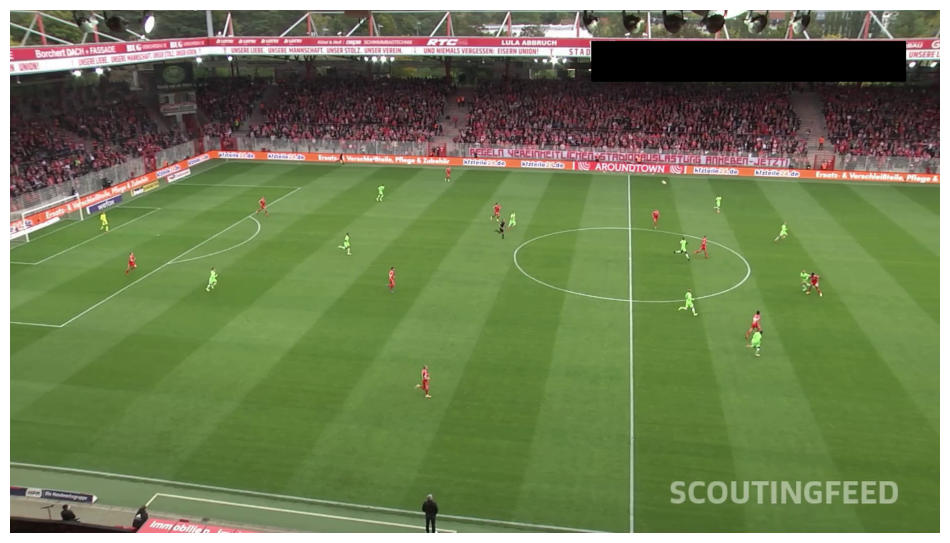

In [7]:
import supervision as sv

SOURCE_VIDEO_PATH = "content\\121364_0.mp4"   

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

sv.plot_image(frame)

## Labeled Visuals

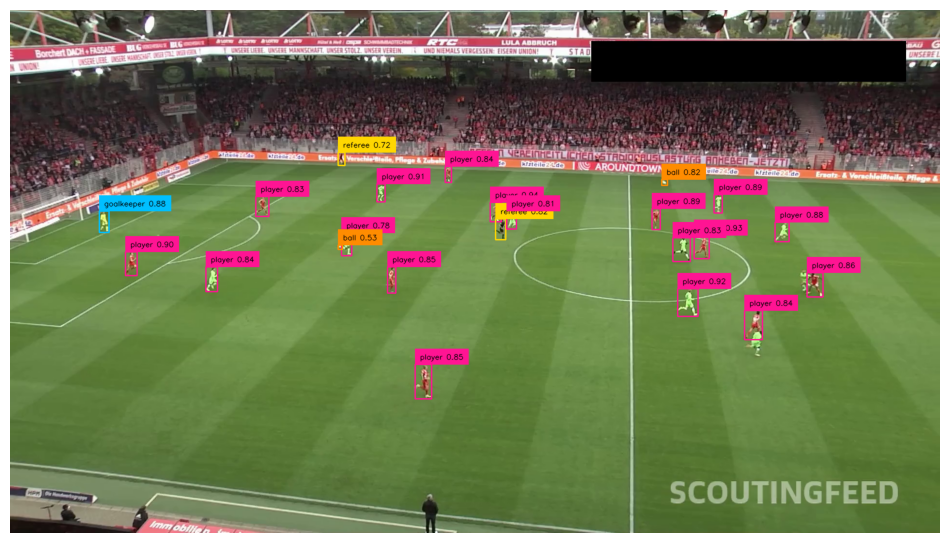

In [8]:
import supervision as sv

SOURCE_VIDEO_PATH = "content\\121364_0.mp4"  

box_annotator = sv.BoxAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000')
)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

labels = [
    f"{class_name} {confidence:.2f}"
    for class_name, confidence
    in zip(detections['class_name'], detections.confidence)
]

annotated_frame = frame.copy()
annotated_frame = box_annotator.annotate(
    scene=annotated_frame,
    detections=detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=detections,
    labels=labels)

sv.plot_image(annotated_frame)

### Create Video with Updated Visuals (#)

In [ ]:
from tqdm import tqdm
import supervision as sv
import tempfile
import cv2
import os

SOURCE_VIDEO_PATH = r"content\121364_0.mp4"
TARGET_VIDEO_PATH = r"content\121364_0_result_1.mp4"

BALL_ID = 0

box_annotator = sv.BoxAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)



label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000')
)

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

with video_sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):
        
        result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
        detections = sv.Detections.from_inference(result)
        
        labels = [
            f"{class_name} {confidence:.2f}"
            for class_name, confidence
            in zip(detections['class_name'], detections.confidence)
        ]
        
        annotated_frame = frame.copy()
        annotated_frame = box_annotator.annotate(annotated_frame, detections)
        annotated_frame = label_annotator.annotate(annotated_frame, detections, labels=labels)
        video_sink.write_frame(annotated_frame)



100%|██████████| 750/750 [05:13<00:00,  2.39it/s]


### Changes to style (#)

In [ ]:
from tqdm import tqdm
import supervision as sv
import tempfile
import cv2
import os

SOURCE_VIDEO_PATH = r"content\121364_0.mp4"
TARGET_VIDEO_PATH = r"content\121364_0_result_2.mp4"



ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
) ## For the players, refs and goalkeepers

triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)## for the ball

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

with video_sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):
        BALL_ID = 0
        result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
        detections = sv.Detections.from_inference(result)
        
        ball_detections = detections[detections.class_id == BALL_ID]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

        all_detections = detections[detections.class_id != BALL_ID]
        all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)

        labels = [
            f"{class_name} {confidence:.2f}"
            for class_name, confidence
            in zip(detections['class_name'], detections.confidence)
        ]
        
        annotated_frame = frame.copy()
        annotated_frame = ellipse_annotator.annotate(scene=annotated_frame, detections=all_detections)
        annotated_frame = triangle_annotator.annotate(scene=annotated_frame, detections=ball_detections)
        video_sink.write_frame(annotated_frame)



100%|██████████| 750/750 [05:12<00:00,  2.40it/s]


### Pretty Visuals with Numeral Labels (#)


In [4]:
from tqdm import tqdm
import supervision as sv
import tempfile
import cv2
import os

SOURCE_VIDEO_PATH = r"content\121364_0.mp4"
TARGET_VIDEO_PATH = r"content\121364_0_result_3.mp4"



ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
) ## For the players, refs and goalkeepers

triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)## for the ball

label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)



video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

tracker = sv.ByteTrack()
BALL_ID = 0

with video_sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):
        result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
        detections = sv.Detections.from_inference(result)
        
        ball_detections = detections[detections.class_id == BALL_ID]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

        all_detections = detections[detections.class_id != BALL_ID]
        all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
        
        # Track detections to get tracker IDs
        all_detections = tracker.update_with_detections(all_detections)

        labels = [
            f"{tracker_id}" if tracker_id is not None else ""
            for tracker_id in all_detections.tracker_id
        ]
        
        annotated_frame = frame.copy()
        annotated_frame = ellipse_annotator.annotate(scene=annotated_frame, detections=all_detections)
        annotated_frame = triangle_annotator.annotate(scene=annotated_frame, detections=ball_detections)
        annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=all_detections, labels=labels)
        video_sink.write_frame(annotated_frame)



100%|██████████| 750/750 [07:27<00:00,  1.68it/s]


# Using SigLIP, UMAP and KMeans to split players into teams


Note: Before training our player clustering model, we need to gather training data. To do this, we'll sample one frame per second, detect players within those frames, and then crop them out.



In [9]:
from tqdm import tqdm
import supervision as sv

SOURCE_VIDEO_PATH = r"content\\121364_0.mp4"
PLAYER_ID = 2
STRIDE = 30

frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

crops = []

for frame in tqdm(frame_generator, desc='Collecting Crops'):
    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)
    detections = detections.with_nms(threshold=0.5, class_agnostic=True)
    detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

In [10]:
len(crops)

493

Note: Here's a sample (100 elements) of the crops we've gathered.

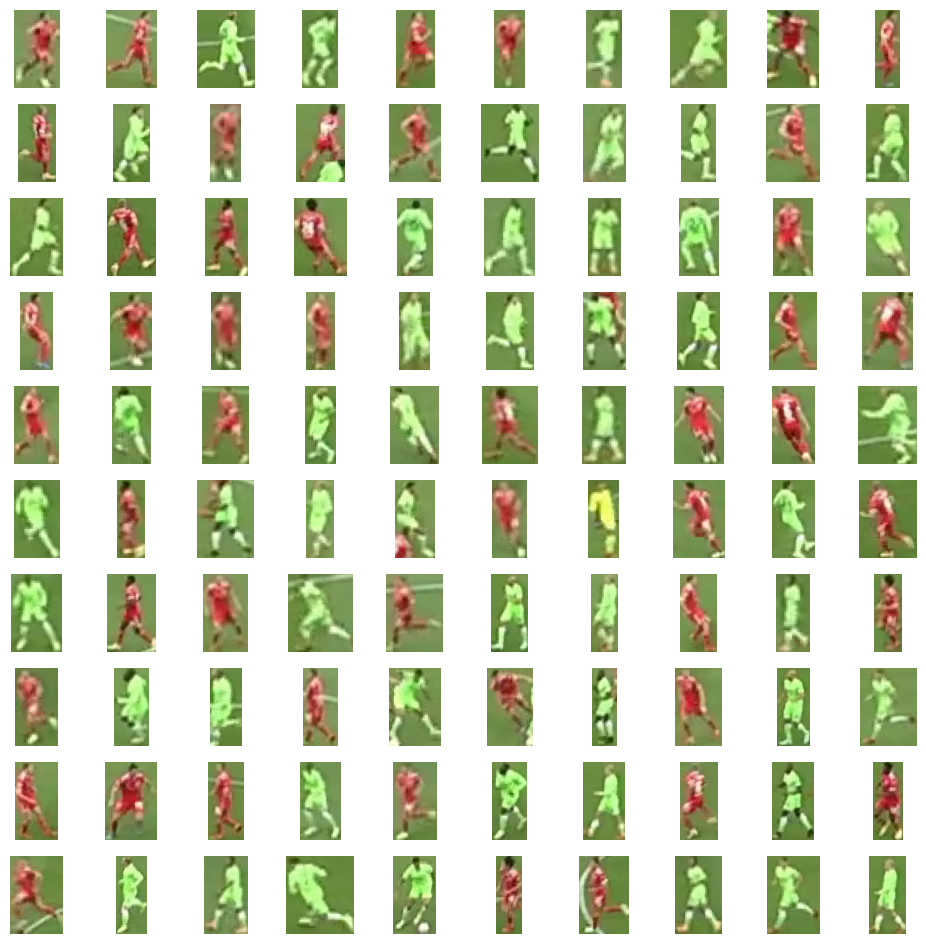

In [11]:
sv.plot_images_grid(crops[:100], grid_size=(10, 10))

Note: Next, we'll run SigLIP to calculate embeddings for each of the crops.

In [12]:
import torch
from transformers import AutoProcessor, SiglipVisionModel

SIGLIP_MODEL_PATH = 'google/siglip-base-patch16-224'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EMBEDDINGS_MODEL = SiglipVisionModel.from_pretrained(SIGLIP_MODEL_PATH).to(DEVICE)
EMBEDDINGS_PROCESSOR = AutoProcessor.from_pretrained(SIGLIP_MODEL_PATH)

In [13]:
import numpy as np
from more_itertools import chunked
from tqdm import tqdm

BATCH_SIZE = 32

crops = [sv.cv2_to_pillow(crop) for crop in crops]
batches = chunked(crops, BATCH_SIZE)
data = []
with torch.no_grad():
    for batch in tqdm(batches, desc='Calculating Embeddings'):
        inputs = EMBEDDINGS_PROCESSOR(images=batch, return_tensors='pt').to(DEVICE)
        outputs = EMBEDDINGS_MODEL(**inputs)
        embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()
        data.append(embeddings)
data = np.concatenate(data)
        


Calculating Embeddings: 16it [00:24,  1.56s/it]


In [14]:
data.shape

(493, 768)

Note: Using UMAP, we project our embeddings from (N, 768) to (N, 3) and then perform a two-cluster division using KMeans.

In [15]:
import umap
from sklearn.cluster import KMeans

REDUCER = umap.UMAP(n_components=3)
CLUSTERING_MODEL = KMeans(n_clusters=2)

In [16]:
projections = REDUCER.fit_transform(data)
clusters = CLUSTERING_MODEL.fit_predict(projections)

In [17]:
projections.shape

(493, 3)

In [18]:
clusters[:10]

array([0, 0, 1, 1, 0, 0, 1, 1, 0, 0], dtype=int32)

In [19]:
team_0 = [
    crop for crop, cluster in zip(crops, clusters) if cluster == 0
]

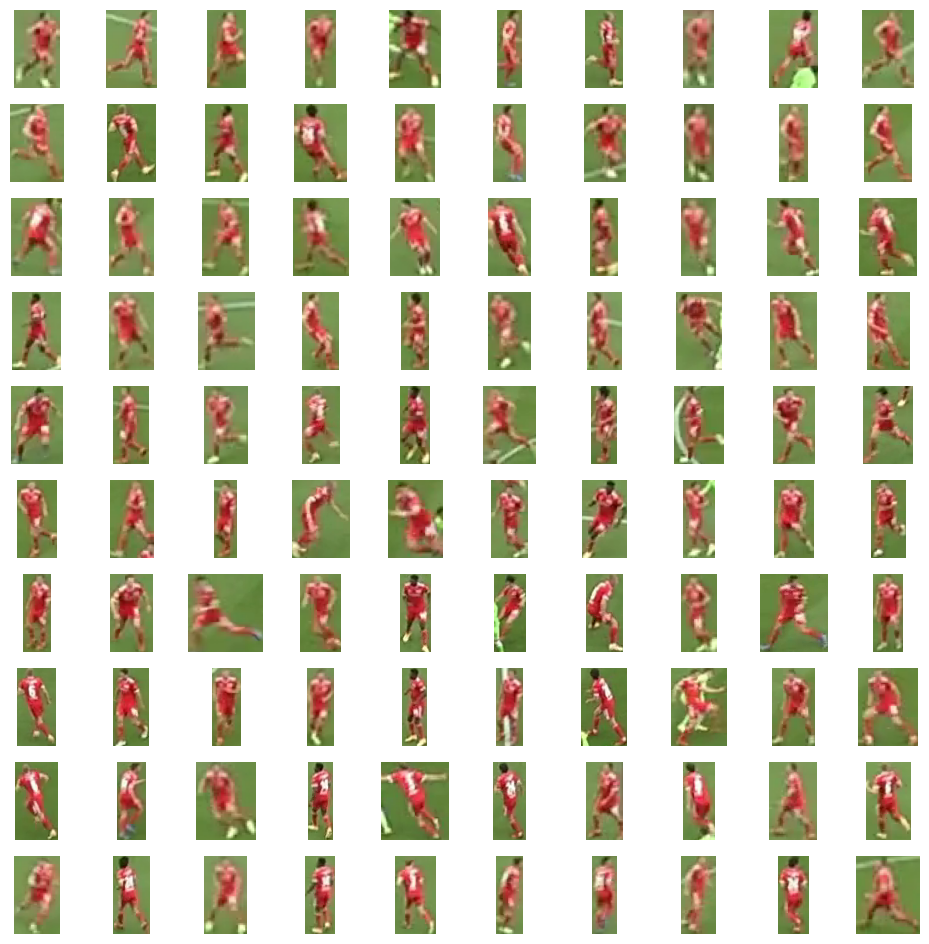

In [20]:
sv.plot_images_grid(team_0[:100], grid_size=(10,10))

## This is an interactive visualization of our results. Click on a dot to display its associated crop. (UNCOMPLETED)

In [26]:
import plotly.graph_objects as go
import numpy as np
from typing import Dict, List
from IPython.core.display import display, HTML
from PIL import Image
import base64
from io import BytesIO


def pil_image_to_data_uri(image: Image.Image) -> str:
    buffered = BytesIO()
    image.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return f"data:image/png;base64,{img_str}"


def display_projections(
    labels: np.ndarray,
    projections: np.ndarray,
    images: List[Image.Image],
    show_legend: bool = False,
    show_markers_with_text: bool = True
) -> None:
    image_data_uris = {f"image_{i}": pil_image_to_data_uri(image) for i, image in enumerate(images)}
    image_ids = np.array([f"image_{i}" for i in range(len(images))])

    unique_labels = np.unique(labels)
    traces = []
    for unique_label in unique_labels:
        mask = labels == unique_label
        customdata_masked = image_ids[mask]
        trace = go.Scatter3d(
            x=projections[mask][:, 0],
            y=projections[mask][:, 1],
            z=projections[mask][:, 2],
            mode='markers+text' if show_markers_with_text else 'markers',
            text=labels[mask],
            customdata=customdata_masked,
            name=str(unique_label),
            marker=dict(size=8),
            hovertemplate="<b>class: %{text}</b><br>image ID: %{customdata}<extra></extra>"
        )
        traces.append(trace)

    # Calculate shared range for cube appearance
    all_axes = projections
    min_val = np.min(all_axes)
    max_val = np.max(all_axes)
    padding = (max_val - min_val) * 0.05
    axis_range = [min_val - padding, max_val + padding]

    fig = go.Figure(data=traces)
    fig.update_layout(
        scene=dict(
            xaxis=dict(title='X', range=axis_range),
            yaxis=dict(title='Y', range=axis_range),
            zaxis=dict(title='Z', range=axis_range),
            aspectmode='cube'  # Ensures equal scaling
        ),
        width=1000,
        height=1000,
        showlegend=show_legend
    )

    plotly_div = fig.to_html(full_html=False, include_plotlyjs=False, div_id="scatter-plot-3d")

    javascript_code = f"""
    <script>
        function displayImage(imageId) {{
            var imageElement = document.getElementById('image-display');
            var placeholderText = document.getElementById('placeholder-text');
            var imageDataURIs = {image_data_uris};
            imageElement.src = imageDataURIs[imageId];
            imageElement.style.display = 'block';
            placeholderText.style.display = 'none';
        }}

        var chartElement = document.getElementById('scatter-plot-3d');

        chartElement.on('plotly_click', function(data) {{
            var customdata = data.points[0].customdata;
            displayImage(customdata);
        }});
    </script>
    """

    html_template = f"""
    <!DOCTYPE html>
    <html>
        <head>
            <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
            <style>
                #image-container {{
                    position: fixed;
                    top: 0;
                    left: 0;
                    width: 200px;
                    height: 200px;
                    padding: 5px;
                    border: 1px solid #ccc;
                    background-color: white;
                    z-index: 1000;
                    box-sizing: border-box;
                    display: flex;
                    align-items: center;
                    justify-content: center;
                    text-align: center;
                }}
                #image-display {{
                    width: 100%;
                    height: 100%;
                    object-fit: contain;
                }}
            </style>
        </head>
        <body>
            {plotly_div}
            <div id="image-container">
                <img id="image-display" src="" alt="Selected image" style="display: none;" />
                <p id="placeholder-text">Click on a data entry to display an image</p>
            </div>
            {javascript_code}
        </body>
    </html>
    """

    display(HTML(html_template))

display_projections(clusters, projections, crops)

ImportError: cannot import name 'display' from 'IPython.core.display' (c:\Users\mwghe\Desktop\VeoVision\.venv\Lib\site-packages\IPython\core\display.py)

Added the extract_crops function. It extracts player crops from a video using the same logic as Cell 20

In [21]:
def extract_crops(video_path: str, player_id: int = 2, stride: int = 30, confidence: float = 0.3):
    """
    Extract player crops from a video.
    
    Args:
        video_path: Path to the video file
        player_id: Class ID for players (default: 2)
        stride: Frame stride for sampling (default: 30)
        confidence: Detection confidence threshold (default: 0.3)
    
    Returns:
        List of cropped player images
    """
    from tqdm import tqdm
    import supervision as sv
    
    frame_generator = sv.get_video_frames_generator(source_path=video_path, stride=stride)
    crops = []
    
    for frame in tqdm(frame_generator, desc='Collecting Crops'):
        result = PLAYER_DETECTION_MODEL.infer(frame, confidence=confidence)[0]
        detections = sv.Detections.from_inference(result)
        detections = detections.with_nms(threshold=0.5, class_agnostic=True)
        detections = detections[detections.class_id == player_id]
        players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
        crops += players_crops
    
    return crops


## Assigned teams to the players (logical error: gk assigned to the wrong team

Note: To simplify the use of the SigLIP, UMAP, and KMeans combo, I've packaged all these models into a TeamClassifier that you can find in the sports repository. (look at teams.py)

In [22]:
from tqdm import tqdm
import supervision as sv
import tempfile
import cv2
import os
from sports.common.team import TeamClassifier

SOURCE_VIDEO_PATH = r"content\\121364_0.mp4"
TARGET_VIDEO_PATH = r"content\\121364_0_mytest.mp4"

crops = extract_crops(SOURCE_VIDEO_PATH)
team_classifier = TeamClassifier(device=DEVICE)
team_classifier.fit(crops)


ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
) ## For the players, refs and goalkeepers

triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)## for the ball

label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)


video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

tracker = sv.ByteTrack()
BALL_ID = 0
PLAYER_ID = 2

with video_sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):
        result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
        detections = sv.Detections.from_inference(result)
        
        ball_detections = detections[detections.class_id == BALL_ID]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

        all_detections = detections[detections.class_id != BALL_ID]
        all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
        
        # Track detections to get tracker IDs
        all_detections = tracker.update_with_detections(all_detections)

        players_detections = all_detections[all_detections.class_id == PLAYER_ID]
        players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
        players_detections.class_id = team_classifier.predict(players_crops)


        labels = [
            f"{tracker_id}" if tracker_id is not None else ""
            for tracker_id in players_detections.tracker_id
        ]
        
        annotated_frame = frame.copy()
        annotated_frame = ellipse_annotator.annotate(scene=annotated_frame, detections=players_detections)
        annotated_frame = triangle_annotator.annotate(scene=annotated_frame, detections=ball_detections)
        annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=players_detections, labels=labels)
        video_sink.write_frame(annotated_frame)



Embedding extraction: 16it [00:24,  1.50s/it]
  0%|          | 0/750 [00:00<?, ?it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.09it/s]
  0%|          | 1/750 [00:03<47:25,  3.80s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.10it/s]
  0%|          | 2/750 [00:04<27:10,  2.18s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.08it/s]
  0%|          | 3/750 [00:05<20:51,  1.67s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.08it/s]
  1%|          | 4/750 [00:06<17:50,  1.43s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.02it/s]
  1%|          | 5/750 [00:08<16:27,  1.32s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.03it/s]
  1%|          | 6/750 [00:09<15:33,  1.25s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.10it/s]
  1%|          | 7/750 [

## STOP HERE CONTINUE TOMMORROW: 44:36